In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import random
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [4]:
%load_ext autoreload
%autoreload

### Read Data

In [5]:
%%time
df_dict = {}
for i in range(5):
    df_dict[i] = read_file(f"../{PROCESSED_DATA_PATH}/v9/validation_fold{i}.parquet")

Shape of data: (82603, 4370)
Shape of data: (82603, 4370)
Shape of data: (82603, 4370)
Shape of data: (82602, 4370)
Shape of data: (82602, 4370)
CPU times: user 15.1 s, sys: 10.4 s, total: 25.4 s
Wall time: 13.1 s


In [6]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")
target = labels["target"].values

Shape of data: (458913, 2)


In [7]:
y_dict = {}
for i in range(5):
    y_dict[i] = df_dict[i]["target"].copy()

In [8]:
%%time
for i in range(5):
    df_dict[i] = df_dict[i].drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 577 ms, sys: 3.24 s, total: 3.82 s
Wall time: 5.61 s


0

In [9]:
cat_features = get_cols(df_dict[0], CATEGORY_COLUMNS)
print(cat_features)

[]


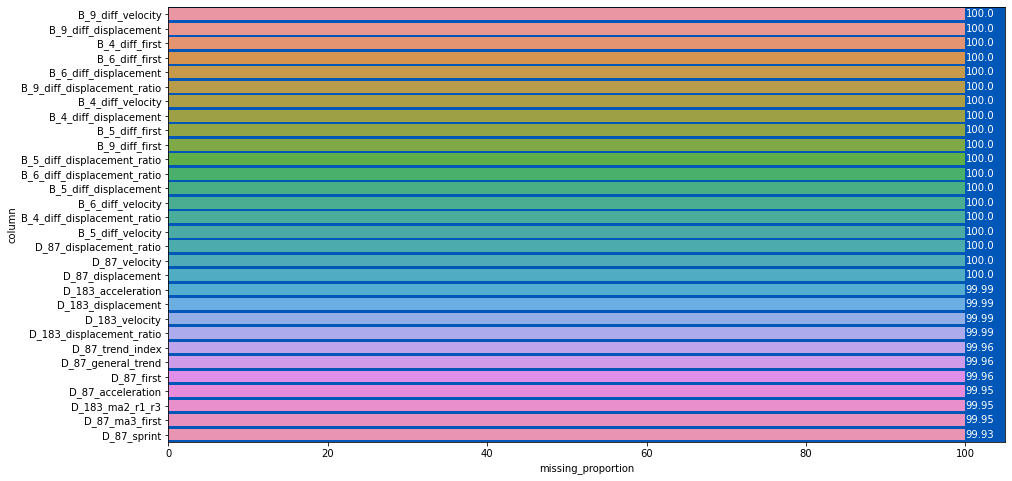

In [11]:
m = plot_missing_proportion_barchart(df_dict[0])

In [14]:
high_missing_columns = m.loc[m["missing_proportion"] > 99.4]["column"].tolist()
len(high_missing_columns)

101

In [15]:
%%time
for df in tqdm(df_dict.values()):
    df = df.drop(columns=high_missing_columns, errors="ignore")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]

CPU times: user 592 ms, sys: 3.83 s, total: 4.42 s
Wall time: 7.22 s


In [72]:
%%time
for df in tqdm(df_dict.values()):
    df.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore", inplace=True)
gc.collect()

CPU times: user 591 ms, sys: 3.81 s, total: 4.4 s
Wall time: 9.89 s


1718

In [25]:
cat_features = get_cols(df_dict[0], CATEGORY_COLUMNS)

In [26]:
print(cat_features)

[]


In [28]:
# train_agg.shape, target.shape

### Train LGBM using pre-set hyperparams

In [63]:
seed = 6666

In [64]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': seed,
    'num_leaves': 96,
    'learning_rate': 0.0105,
    'feature_fraction': 0.2,
    'bagging_freq': 7,
    'bagging_fraction': 0.55,
    'n_jobs': -1,
    'lambda_l2': 12,
    'min_data_in_leaf': 160,
    'scale_pos_weight': 1.33,
    'drop_rate': 0.1,
    'skip_drop': 0.55,
}

In [65]:
target = labels["target"].values

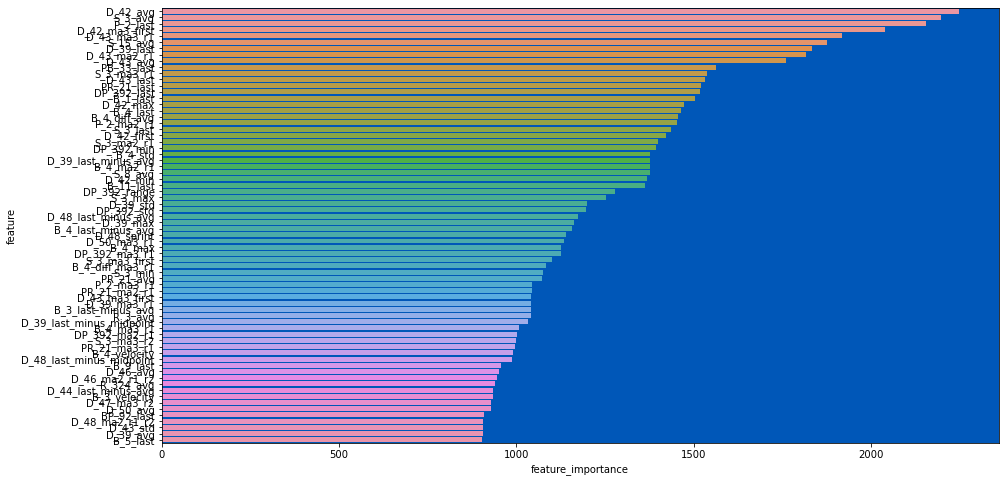

In [66]:
m = plot_feature_importance(model.feature_name(), model.feature_importance(), limit=70)

In [67]:
noob_features1 = m.loc[m["feature_importance"] < 5]["feature"].tolist()

In [74]:
%%time
for df in tqdm(df_dict.values()):
    df.drop(columns=noob_features1, errors="ignore", inplace=True)
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]

CPU times: user 550 ms, sys: 2.57 s, total: 3.11 s
Wall time: 4.37 s


0

In [75]:
print(df_dict[0].shape)

(82603, 3819)


In [76]:
for fold in range(5):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {df_dict[0].shape[1]} features...')
    print('-'*50)
    x_train = pd.concat([df for idx, df in df_dict.items() if idx != fold], ignore_index=True)
    x_val = df_dict[fold]
    print("X shape: ", x_train.shape, x_val.shape)
    y_train = pd.concat([y_dict[idx] for idx in range(5) if idx != fold], ignore_index=True)
    y_val = y_dict[fold]
    print("Y shape: ", y_train.shape, y_val.shape)
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features)
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 10500,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 1000,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'./models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 3819 features...
--------------------------------------------------
X shape:  (330410, 3819) (82603, 3819)
Y shape:  (330410,) (82603,)
[LightGBM] [Warning] Unknown parameter: skip_rate
[LightGBM] [Warning] Unknown parameter: skip_rate
[LightGBM] [Info] Number of positive: 85542, number of negative: 244868
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.021584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626586
[LightGBM] [Info] Number of data points in the train set: 330410, number of used features: 3819
[LightGBM] [Warning] Unknown parameter: skip_rate
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258897 -> initscore=-1.051712
[LightGBM] [Info] Start training from score -1.051712
[1000]	training's binary_logloss: 0.252688	training's amex: 0.791765	vali


KeyboardInterrupt



Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x281195000>> (for post_execute):


KeyboardInterrupt: 